In [6]:
import boto3
import pandas as pd
import numpy as np
import awswrangler as wr
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [13]:
# Abres un cliente de S3
session = boto3.Session(profile_name='arquitectura')

In [14]:
query = '''
    SELECT *
    FROM marketplace.orders;
'''

orders_data = wr.athena.read_sql_query(
    query, 
    database="orders", 
    ctas_approach=False,
    boto3_session=session
)

orders_data.head()

,id,status,date_created,date_closed,total_amount,currency_id,buyer_id,buyer_nickname,item_id,item_title,quantity,unit_price,payment_id,transaction_amount,payment_status
0,1,paid,2023-11-18T01:21:30.000-04:00,2023-11-18T01:21:33.000-04:00,3016.0,MXN,309239735,CHAN3676282,MLM2599141944,Colchn Gel Dreams Individual Memory Foam Gel +...,1,3016.0,<NA>,3016.0,approved
1,2,cancelled,2023-11-18T08:24:01.000-04:00,2023-11-18T08:24:02.000-04:00,3016.0,MXN,1100694423,JUANOLMOSSALINAS,MLM2599141944,Colchn Gel Dreams Individual Memory Foam Gel +...,1,3016.0,<NA>,3016.0,refunded
2,3,paid,2023-11-18T10:46:37.000-04:00,2023-11-18T10:47:25.000-04:00,6799.5,MXN,337111761,USSINAVA,MLM2595260414,Colchones Matrimoniales | Colchn Memory Foam +...,1,6799.5,<NA>,6799.5,approved
3,4,cancelled,2023-11-18T11:31:07.000-04:00,2023-11-18T11:31:45.000-04:00,3016.0,MXN,1437574340,ZUIGAELENA20230803130736,MLM2599141944,Colchn Gel Dreams Individual Memory Foam Gel +...,1,3016.0,<NA>,3016.0,refunded
4,5,paid,2023-11-18T19:36:29.000-04:00,2023-11-18T19:36:32.000-04:00,3016.0,MXN,1007811151,JESSJAIMEJUANFRANCISCO,MLM2599141944,Colchn Gel Dreams Individual Memory Foam Gel +...,1,3016.0,<NA>,3016.0,approved


In [15]:
# Convertir la columna de fecha
orders_data['date_created'] = pd.to_datetime(orders_data['date_created'])
orders_data.head()




,id,status,date_created,date_closed,total_amount,currency_id,buyer_id,buyer_nickname,item_id,item_title,quantity,unit_price,payment_id,transaction_amount,payment_status
0,1,paid,2023-11-18 01:21:30-04:00,2023-11-18T01:21:33.000-04:00,3016.0,MXN,309239735,CHAN3676282,MLM2599141944,Colchn Gel Dreams Individual Memory Foam Gel +...,1,3016.0,<NA>,3016.0,approved
1,2,cancelled,2023-11-18 08:24:01-04:00,2023-11-18T08:24:02.000-04:00,3016.0,MXN,1100694423,JUANOLMOSSALINAS,MLM2599141944,Colchn Gel Dreams Individual Memory Foam Gel +...,1,3016.0,<NA>,3016.0,refunded
2,3,paid,2023-11-18 10:46:37-04:00,2023-11-18T10:47:25.000-04:00,6799.5,MXN,337111761,USSINAVA,MLM2595260414,Colchones Matrimoniales | Colchn Memory Foam +...,1,6799.5,<NA>,6799.5,approved
3,4,cancelled,2023-11-18 11:31:07-04:00,2023-11-18T11:31:45.000-04:00,3016.0,MXN,1437574340,ZUIGAELENA20230803130736,MLM2599141944,Colchn Gel Dreams Individual Memory Foam Gel +...,1,3016.0,<NA>,3016.0,refunded
4,5,paid,2023-11-18 19:36:29-04:00,2023-11-18T19:36:32.000-04:00,3016.0,MXN,1007811151,JESSJAIMEJUANFRANCISCO,MLM2599141944,Colchn Gel Dreams Individual Memory Foam Gel +...,1,3016.0,<NA>,3016.0,approved


In [16]:
# Agregar las ventas diarias
daily_sales = orders_data.groupby(orders_data['date_created'].dt.date).agg({'total_amount': 'sum'}).reset_index()
daily_sales.columns = ['date', 'total_sales']

# Asegurarse de que la fecha esté en el índice y establecer la frecuencia
daily_sales['date'] = pd.to_datetime(daily_sales['date'])
daily_sales.set_index('date', inplace=True)
daily_sales = daily_sales.asfreq('D')

# Dividir los datos en entrenamiento y prueba
train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]

orders_data.head()

,id,status,date_created,date_closed,total_amount,currency_id,buyer_id,buyer_nickname,item_id,item_title,quantity,unit_price,payment_id,transaction_amount,payment_status
0,1,paid,2023-11-18 01:21:30-04:00,2023-11-18T01:21:33.000-04:00,3016.0,MXN,309239735,CHAN3676282,MLM2599141944,Colchn Gel Dreams Individual Memory Foam Gel +...,1,3016.0,<NA>,3016.0,approved
1,2,cancelled,2023-11-18 08:24:01-04:00,2023-11-18T08:24:02.000-04:00,3016.0,MXN,1100694423,JUANOLMOSSALINAS,MLM2599141944,Colchn Gel Dreams Individual Memory Foam Gel +...,1,3016.0,<NA>,3016.0,refunded
2,3,paid,2023-11-18 10:46:37-04:00,2023-11-18T10:47:25.000-04:00,6799.5,MXN,337111761,USSINAVA,MLM2595260414,Colchones Matrimoniales | Colchn Memory Foam +...,1,6799.5,<NA>,6799.5,approved
3,4,cancelled,2023-11-18 11:31:07-04:00,2023-11-18T11:31:45.000-04:00,3016.0,MXN,1437574340,ZUIGAELENA20230803130736,MLM2599141944,Colchn Gel Dreams Individual Memory Foam Gel +...,1,3016.0,<NA>,3016.0,refunded
4,5,paid,2023-11-18 19:36:29-04:00,2023-11-18T19:36:32.000-04:00,3016.0,MXN,1007811151,JESSJAIMEJUANFRANCISCO,MLM2599141944,Colchn Gel Dreams Individual Memory Foam Gel +...,1,3016.0,<NA>,3016.0,approved


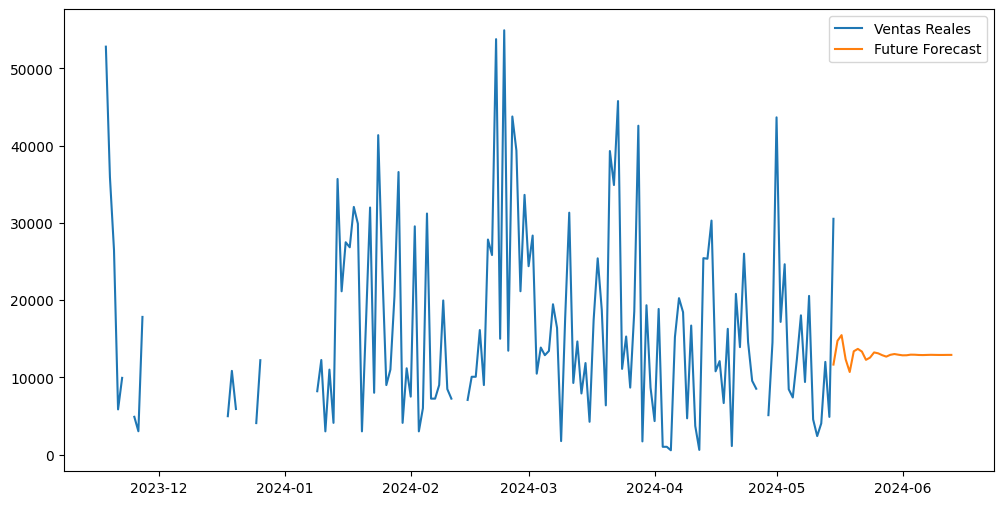

In [17]:
# Entrenar el modelo ARIMA
model = ARIMA(train['total_sales'], order=(5, 1, 0))  # (p, d, q) son los hiperparámetros de ARIMA
model_fit = model.fit()

# Hacer predicciones después del período de prueba
future_forecast = model_fit.forecast(steps=30)

# Crear una serie de tiempo unificada para las ventas reales
all_sales = pd.concat([train, test])

# Visualizar las predicciones y los datos reales
plt.figure(figsize=(12, 6))
plt.plot(all_sales['total_sales'], label='Ventas Reales')
plt.plot(pd.date_range(start=all_sales.index[-1], periods=30, freq='D'), future_forecast, label='Future Forecast')
plt.legend(loc='best')
plt.show()